In [1]:
# === 1) Install dependencies (deap for GP) ===
!pip install deap
!pip install scikit-image


  Using cached deap-1.4.3-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached deap-1.4.3-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (135 kB)


Original and noisy sample:


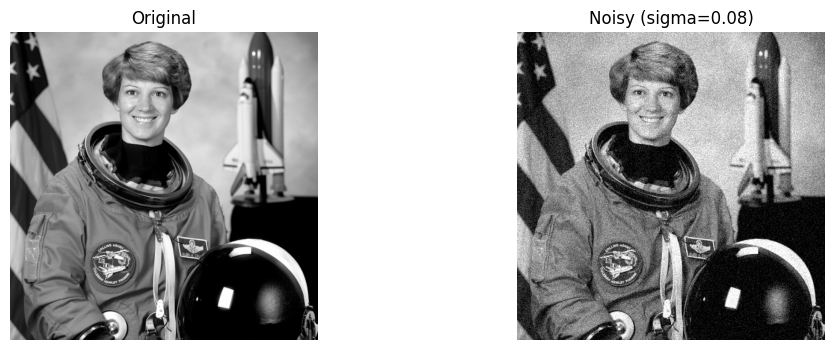

Running GA optimization (this may take ~1-2 minutes)...
GA gen 1/18, best so far SSIM=0.7475, best params=[0.23217104816053338, 8.424049053087128, 5]
GA gen 2/18, best so far SSIM=0.7475, best params=[0.23217104816053338, 8.424049053087128, 5]
GA gen 3/18, best so far SSIM=0.7478, best params=[0.25183019852054966, 3.7675793635502255, 5]
GA gen 4/18, best so far SSIM=0.7488, best params=[0.25183019852054966, 7.387216335794335, 5]
GA gen 5/18, best so far SSIM=0.7490, best params=[0.2645478816000846, 7.387216335794335, 5]
GA gen 6/18, best so far SSIM=0.7490, best params=[0.2645478816000846, 7.884970029549841, 5]
GA gen 7/18, best so far SSIM=0.7490, best params=[0.2645478816000846, 7.884970029549841, 5]
GA gen 8/18, best so far SSIM=0.7490, best params=[0.2645478816000846, 7.884970029549841, 5]
GA gen 9/18, best so far SSIM=0.7490, best params=[0.26244607269992093, 7.884970029549841, 5]
GA gen 10/18, best so far SSIM=0.7490, best params=[0.26244607269992093, 7.884970029549841, 5]
GA gen

/usr/local/lib/python3.12/dist-packages/deap/gp.py:257: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg        	min       	std       
0  	200   	3.74205e+11	0.00514079	5.2788e+12
1  	120   	919906     	0.00237091	1.21963e+07
2  	134   	35914.8    	0.00200967	506588     
3  	133   	24.6733    	0.00200967	261.13     
4  	120   	62329.2    	0         	791516     
5  	122   	16255.4    	0         	229299     
6  	137   	119738     	0         	1.68901e+06
7  	134   	80.8946    	0         	1117.37    
8  	129   	5804.64    	0         	81876.7    
9  	131   	0.559442   	0         	4.61456    
10 	119   	43637      	0         	615544     
11 	129   	0.359221   	0         	2.38772    
12 	146   	92.98      	0         	1002.62    
13 	124   	0.978935   	0         	10.2649    
14 	128   	202.453    	0         	2815.22    
15 	125   	7.53952    	0         	77.9213    
16 	135   	2.22141    	0         	27.4779    
17 	141   	27.5145    	0         	353.406    
18 	137   	0.394582   	0         	1.6741     
19 	131   	1654.52    	0         	23041.9    
20 	133   	3.13287e+10	0         	4.

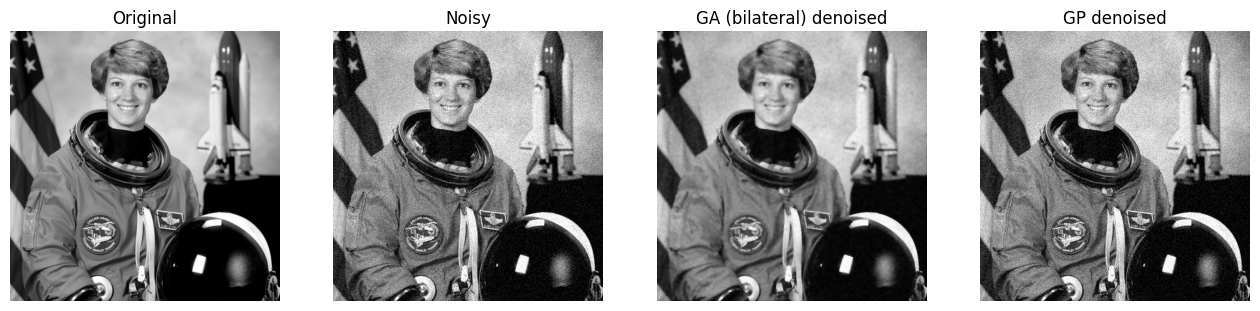

Short comparison:
- GA optimized parameters: [0.2626069471462671, 7.884970029549841, 5] -> SSIM=0.7490, PSNR=28.48
- GP evolved function -> SSIM=0.4159, PSNR=22.42

Notes:
 - GA optimizes parameters of a standard denoising filter (bilateral). It's fast at inference and preserves edges.
 - GP evolves an expression that maps a 3x3 neighborhood to the center pixel. It can learn custom local rules but
   may be slower at inference (sliding-window application) and prone to overfitting unless regularized or trained on many patches.
 - Depending on seeds, population sizes, and number of generations results will vary. Use larger GP populations/generations for better fit,
   and consider adding parsimony pressure to penalize complexity (bloat).
Saved denoised images to /content/den_ga.png and /content/den_gp.png


In [5]:
# Google Colab-ready: compare GA-based parameter optimization vs Genetic Programming (GP)
# for an image denoising task.
#
# Sections:
# 1) Install deps (deap)
# 2) Load image, add noise, extract patches
# 3) GA: optimize bilateral filter parameters (sigma_color, sigma_spatial, win_size)
# 4) GP: evolve pixel-regression expression mapping 3x3 neighborhood -> center pixel
# 5) Evaluate and compare (PSNR, SSIM) and show images



# === 2) Imports and utilities ===
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, util, restoration, metrics
from skimage.filters import median
from skimage.morphology import disk
from skimage.restoration import denoise_bilateral
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import math
import time
import operator # Import the operator module

# For GP
from deap import base, creator, gp, tools, algorithms

random.seed(42)
np.random.seed(42)

# Utility: show images side-by-side
def show_images(images, titles=None, cmap='gray', figsize=(12,4)):
    n = len(images)
    plt.figure(figsize=figsize)
    for i,img in enumerate(images):
        plt.subplot(1,n,i+1)
        plt.imshow(img, cmap=cmap)
        plt.axis('off')
        if titles and i < len(titles):
            plt.title(titles[i])
    plt.show()

# === 3) Load image and create noisy version ===
img_color = data.astronaut()  # color image
img_gray = color.rgb2gray(img_color)  # float64 in [0,1]
img_gray = util.img_as_float(img_gray)

sigma_noise = 0.08
noisy = util.random_noise(img_gray, mode='gaussian', var=sigma_noise**2)

print("Original and noisy sample:")
show_images([img_gray, noisy], titles=['Original', f'Noisy (sigma={sigma_noise})'])

# Create train patches (for GP) and separate validation test image
# Extract many 3x3 patches from image for GP training
def extract_patches(img, patch_size=3, num_patches=2000):
    h,w = img.shape
    ps = patch_size
    half = ps//2
    patches = []
    for _ in range(num_patches):
        r = np.random.randint(half, h-half)
        c = np.random.randint(half, w-half)
        patch = img[r-half:r+half+1, c-half:c+half+1].flatten()
        center = img[r,c]
        patches.append((patch, center))
    return patches

patches = extract_patches(img_gray, patch_size=3, num_patches=4000)
train_patches = patches[:3000]
val_patches = patches[3000:]

# Helper to compute SSIM and PSNR for comparing images
def eval_metrics(orig, deno):
    return {
        'psnr': psnr(orig, deno, data_range=1.0),
        'ssim': ssim(orig, deno, data_range=1.0)
    }

# === 4) Genetic Algorithm (GA): optimize bilateral filter parameters ===
# Chromosome: [sigma_color (0.01-0.5), sigma_spatial (0.5-10), win_size_odd (3-15 odd)]
# Fitness: SSIM between denoised image and original

def random_individual():
    sigma_color = random.uniform(0.01, 0.5)
    sigma_spatial = random.uniform(0.5, 10.0)
    win = random.choice([3,5,7,9,11,13,15])
    return [sigma_color, sigma_spatial, win]

def mutate_ind(ind, prob=0.2):
    if random.random() < prob:
        ind[0] = min(0.5, max(0.01, ind[0] + random.uniform(-0.05, 0.05)))
    if random.random() < prob:
        ind[1] = min(10.0, max(0.5, ind[1] + random.uniform(-1.0, 1.0)))
    if random.random() < prob:
        ind[2] = random.choice([3,5,7,9,11,13,15])
    return ind

def crossover(a,b):
    # simple one-point-ish crossover
    child1 = [a[0], b[1], a[2]]
    child2 = [b[0], a[1], b[2]]
    return child1, child2

def fitness_ga(individual, noisy_img, orig_img):
    sigma_color, sigma_spatial, win = individual
    den = denoise_bilateral(
        noisy_img,
        sigma_color=sigma_color,
        sigma_spatial=sigma_spatial,
        win_size=win,
        channel_axis=None   # <- FIX
    )
    val = ssim(orig_img, den, data_range=1.0)
    return val

def run_ga(noisy_img, orig_img, pop_size=20, generations=15):
    pop = [random_individual() for _ in range(pop_size)]
    best = None
    bestscore = -1
    for g in range(generations):
        scored = []
        for ind in pop:
            score = fitness_ga(ind, noisy_img, orig_img)
            scored.append((score, ind))
            if score > bestscore:
                bestscore = score
                best = ind.copy()
        scored.sort(reverse=True, key=lambda x: x[0])
        # Elitism: keep top 2
        newpop = [scored[0][1], scored[1][1]]
        while len(newpop) < pop_size:
            a = max(random.sample(scored, 3))[1]
            b = max(random.sample(scored, 3))[1]
            c1, c2 = crossover(a,b)
            c1 = mutate_ind(c1, prob=0.3)
            c2 = mutate_ind(c2, prob=0.3)
            newpop.append(c1)
            if len(newpop) < pop_size:
                newpop.append(c2)
        pop = newpop
        print(f"GA gen {g+1}/{generations}, best so far SSIM={bestscore:.4f}, best params={best}")
    # Final denoising with best params
    den_best = denoise_bilateral(
        noisy_img,
        sigma_color=best[0],
        sigma_spatial=best[1],
        win_size=best[2],
        channel_axis=None   # <- FIX here too
    )
    return best, den_best, bestscore


print("Running GA optimization (this may take ~1-2 minutes)...")
t0 = time.time()
best_params, den_ga_img, ga_score = run_ga(noisy, img_gray, pop_size=24, generations=18)
t1 = time.time()
print("GA finished in %.1f sec" % (t1-t0))
print("Best GA params:", best_params)
print("GA metrics:", eval_metrics(img_gray, den_ga_img))

# === 5) Genetic Programming (GP): evolve expression f(neighborhood) -> center pixel ===
# We'll use a 3x3 neighborhood (9 inputs). We evolve expressions using DEAP GP to predict center pixel.
#
# NOTE: This is a simplified GP regression. It evolves mathematical expressions that combine neighbor pixel values,
# which can capture local smoothing/edge-aware behavior. Training uses patches extracted earlier.

# Prepare training data
X_train = np.array([p[0] for p in train_patches])  # shape (n,9)
y_train = np.array([p[1] for p in train_patches])
X_val = np.array([p[0] for p in val_patches])
y_val = np.array([p[1] for p in val_patches])

# Define primitive set
pset = gp.PrimitiveSet("MAIN", 9)
# rename args to p0..p8 (3x3 flatten)
for i in range(9):
    pset.renameArguments(**{f'ARG{i}': f'p{i}'})

# Add operators
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.subtract, 2)
pset.addPrimitive(np.multiply, 2)
# protected division
def protectedDiv(a,b):
    with np.errstate(divide='ignore', invalid='ignore'):
        res = np.where(np.abs(b) < 1e-6, a, a / b)
    return res
pset.addPrimitive(protectedDiv, 2)

# Add some unary ops
def protected_sqrt(a):
    return np.sqrt(np.abs(a))
pset.addPrimitive(protected_sqrt, 1)

def protected_log(a):
    a = np.abs(a)
    return np.where(a<=1e-8, 0.0, np.log(a+1e-8))
pset.addPrimitive(protected_log, 1)

# ephemeral constant
pset.addEphemeralConstant("rand101", lambda: random.uniform(-1,1))

# GP setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # minimize MSE
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr_init", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr_init)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile expression to function
toolbox.register("compile", gp.compile, pset=pset)

# fitness: MSE on a subset (to speed up), we vectorize by evaluating compiled function over dataset
def gp_fitness(individual, X, y, sample_size=800):
    func = toolbox.compile(expr=individual)
    # sample subset for speed
    idx = np.random.choice(len(X), min(sample_size, len(X)), replace=False)
    Xs = X[idx]
    ys = y[idx]
    # evaluate function for each sample
    preds = []
    for row in Xs:
        # call func with 9 scalars
        try:
            val = func(*row)
        except Exception:
            val = 0.0
        preds.append(val)
    preds = np.array(preds, dtype=float)
    mse = np.mean((preds - ys) ** 2)
    return (mse,)

toolbox.register("evaluate", gp_fitness, X=X_train, y=y_train)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Limit height to avoid bloat
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=8))

# Evolution parameters
pop = toolbox.population(n=200)
hof = tools.HallOfFame(3)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("std", np.std)

print("Running GP (this may take several minutes depending on population and generations)...")
start = time.time()
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3, ngen=25, stats=stats, halloffame=hof, verbose=True)
end = time.time()
print("GP finished in %.1f sec" % (end-start))

# Best individual
best_gp = hof[0]
print("Best GP individual:", best_gp)
print("Compiling GP to function...")
gp_func = toolbox.compile(expr=best_gp)

# Apply GP function to whole noisy image in sliding-window manner to denoise
def denoise_with_gp(noisy_img, gp_func):
    h,w = noisy_img.shape
    out = np.zeros_like(noisy_img)
    half = 1  # 3x3
    for r in range(half, h-half):
        for c in range(half, w-half):
            patch = noisy_img[r-half:r+half+1, c-half:c+half+1].flatten()
            try:
                val = gp_func(*patch)
            except Exception:
                val = noisy_img[r,c]
            out[r,c] = np.clip(val, 0.0, 1.0)
    # copy borders from noisy
    out[0:half,:] = noisy_img[0:half,:]
    out[-half:,:] = noisy_img[-half:,:]
    out[:,0:half] = noisy_img[:,0:half]
    out[:,-half:] = noisy_img[:,-half:]
    return out

print("Denoising full image with GP (sliding-window)...")
t0 = time.time()
den_gp_img = denoise_with_gp(noisy, gp_func)
t1 = time.time()
print("GP denoising time: %.1f sec" % (t1-t0))

# === 6) Evaluate and compare ===
orig = img_gray
noisy_metrics = eval_metrics(orig, noisy)
ga_metrics = eval_metrics(orig, den_ga_img)
gp_metrics = eval_metrics(orig, den_gp_img)

print("\nMetrics (PSNR, SSIM):")
print("Noisy:   PSNR=%.3f  SSIM=%.4f" % (noisy_metrics['psnr'], noisy_metrics['ssim']))
print("GA-bilateral: PSNR=%.3f  SSIM=%.4f" % (ga_metrics['psnr'], ga_metrics['ssim']))
print("GP-regressor: PSNR=%.3f  SSIM=%.4f" % (gp_metrics['psnr'], gp_metrics['ssim']))

# show images
show_images([orig, noisy, den_ga_img, den_gp_img],
            titles=['Original', 'Noisy', 'GA (bilateral) denoised', 'GP denoised'],
            figsize=(16,6))

# print short comparison summary
print("Short comparison:")
print(f"- GA optimized parameters: {best_params} -> SSIM={ga_metrics['ssim']:.4f}, PSNR={ga_metrics['psnr']:.2f}")
print(f"- GP evolved function -> SSIM={gp_metrics['ssim']:.4f}, PSNR={gp_metrics['psnr']:.2f}")
print("\nNotes:")
print(" - GA optimizes parameters of a standard denoising filter (bilateral). It's fast at inference and preserves edges.")
print(" - GP evolves an expression that maps a 3x3 neighborhood to the center pixel. It can learn custom local rules but")
print("   may be slower at inference (sliding-window application) and prone to overfitting unless regularized or trained on many patches.")
print(" - Depending on seeds, population sizes, and number of generations results will vary. Use larger GP populations/generations for better fit,")
print("   and consider adding parsimony pressure to penalize complexity (bloat).")

# Save results if desired
import imageio
imageio.imwrite('/content/den_ga.png', (den_ga_img*255).astype(np.uint8))
imageio.imwrite('/content/den_gp.png', (den_gp_img*255).astype(np.uint8))
print("Saved denoised images to /content/den_ga.png and /content/den_gp.png")